___

## Particle Prediction - Using Dense Neural Networks
#### DJ Dawkins, Nathan Deinlein, Joseph Lazarus, and Puri Rudick​

DS7333 QTW: Case Study 6
___

This Notebook will cover the following topics in order: 
1. Business Overview and Objectives
2. Data Evaluation and Engineering
3. Modeling Preparations
4. Model Building and Model Evaluation
5. Model Interpretability and Explainability
6. Conclusions and Discussions

In [3]:
# Imports necessary python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

---
### Business Overview and Objectives
The goal for this case study is to build a classification model using a dense neural network to distinguish between the existance of a new particle or not.

The goal is to maximize the accuracy and describe the decisions made while designing and building the network as well as determining when the model has sufficiently finished training. 

---
### Data Evaluation and Engineering

#### **Data Description:**
- There is a total of 7 million observations in the dataset.
- The dataset contains 28 features (named f0 to f26, and mass).  All features are numerical variables.
    - 22 of the features are continous variables.
    - 6 of the features; f5, f9, f13, f17, f21, and mass, are numerical categorical variables.
- The target variable is binary, called '# label' with 2 values: '0' for Non-Detection and '1' for Detection. The classes are balanced with the positve target value having a prevlaence of ~50%.
    - *3,499,121* observations for '0' or Non-Detection class
    - *3,500,879* observations for '1' or Detection class


In [42]:
# Read in data

# The file is 1.63GB, which is too big for Github
# Save the file locally and read in using the file's path

# path = 'C:/Users/puri.rudick/Downloads/all_train.csv.gz'
path = '/Users/puri/DataScience@SMU/10.DS7333 QTW/all_train.csv.gz'
# path = "C:/Users/OaklandHillsMansion/OneDrive - Southern Methodist University/SMU/DS 7333 Quantify World/QTW_Week11_Files/all_train.csv.gz"

df = pd.read_csv(path, compression='gzip', on_bad_lines='skip')

In [5]:
df.shape

(7000000, 29)

In [7]:
print(df.groupby(['# label'])['# label'].count())

# label
0.0    3499121
1.0    3500879
Name: # label, dtype: int64


#### **Exploratory Data Analysis (EDA):**

**Missing Values and Duplicated Rows**<br>
There is no missing value, and no duplicated rows.

**Statistical Summary Table** of the dataset as shown below.


In [8]:
# Count missing values
df_na = pd.DataFrame(df.isna().sum())
df_na.rename(columns={df_na.columns[0]: 'count'}, inplace = True)

df_na = df_na[df_na['count'] != 0]
df_na['percent_missing'] = df_na['count']/df.shape[0]
df_na = df_na.sort_values('count', ascending=False)

df_na

,count,percent_missing


In [9]:
# Check for duplicate rows
print('Duplicate rows: ', df.duplicated(keep='first').sum())

Duplicate rows:  0


In [6]:
df.describe()

,# label,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass
count,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,...,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06
mean,5.001256e-01,1.612528e-02,4.770022e-04,2.686578e-05,1.056081e-02,-1.050026e-04,2.765919e-03,1.815953e-02,2.510948e-05,4.345870e-04,...,1.164789e-02,-1.127097e-04,7.686731e-05,2.909202e-04,1.228774e-02,9.778378e-03,5.269844e-03,-1.760961e-03,1.533136e-02,1.000107e+03
std,5.000000e-01,1.004417e+00,9.974864e-01,1.000080e+00,9.956003e-01,9.998670e-01,1.000957e+00,9.867746e-01,9.965867e-01,1.000007e+00,...,1.002725e+00,1.000038e+00,1.000033e+00,1.000170e+00,1.010477e+00,1.005418e+00,1.009990e+00,9.844511e-01,9.822799e-01,3.534255e+02
min,0.000000e+00,-1.960549e+00,-2.365355e+00,-1.732165e+00,-9.980274e+00,-1.732137e+00,-1.054221e+00,-3.034787e+00,-2.757853e+00,-1.732359e+00,...,-1.728284e+00,-2.281867e+00,-1.731758e+00,-5.736825e-01,-3.631608e+00,-4.729473e+00,-2.062223e+01,-3.452634e+00,-2.632761e+00,5.000000e+02
25%,0.000000e+00,-7.288206e-01,-7.332548e-01,-8.656704e-01,-6.092291e-01,-8.658025e-01,-1.054221e+00,-7.566092e-01,-7.014146e-01,-8.656543e-01,...,-7.423630e-01,-7.206846e-01,-8.656855e-01,-5.736825e-01,-5.417942e-01,-5.115522e-01,-3.543870e-01,-6.925097e-01,-7.943804e-01,7.500000e+02
50%,1.000000e+00,-3.930319e-02,8.523957e-04,3.199154e-04,1.963316e-02,-5.070131e-04,-5.983562e-03,-1.499527e-01,-1.067553e-04,1.384781e-03,...,-8.992496e-02,-6.735953e-05,-4.424527e-04,-5.736825e-01,-1.602760e-01,-3.144032e-01,-3.265228e-01,-3.570301e-01,-8.828640e-02,1.000000e+03
75%,1.000000e+00,6.900799e-01,7.347832e-01,8.659464e-01,6.798818e-01,8.657646e-01,8.504885e-01,7.686690e-01,7.013194e-01,8.665976e-01,...,6.423185e-01,7.204921e-01,8.659566e-01,-5.736825e-01,4.812194e-01,1.634892e-01,-2.337671e-01,4.753128e-01,7.610846e-01,1.250000e+03
max,1.000000e+00,4.378282e+00,2.365287e+00,1.732370e+00,4.148023e+00,1.731978e+00,4.482618e+00,3.720345e+00,2.758590e+00,1.731450e+00,...,5.866367e+00,2.282217e+00,1.732740e+00,1.743123e+00,7.293420e+00,9.333287e+00,1.499064e+01,5.277313e+00,4.444690e+00,1.500000e+03


**Data Distribution and Correlation**<br>

Data Observations from histograms and correlation heatmap:
- All 22 continous variables (everything except f5, f9, f13, f17, f21, and mass) take on either a normal-ish distribution or a uniform distribution
- For features f0, f3, f6, f10, f14, f18, and f26 the pos. and neg. classes appear to take on noticiably different shapes.<br>
- Feature f24 values for both pos and neg are predominantly 0.<br>
- However, when plot these features on box plots (below), we do not see any major shift between classes in the data.
- The correlation heatmap below clearly displays that there is no evidence of correlation was found among any of the features.<br>

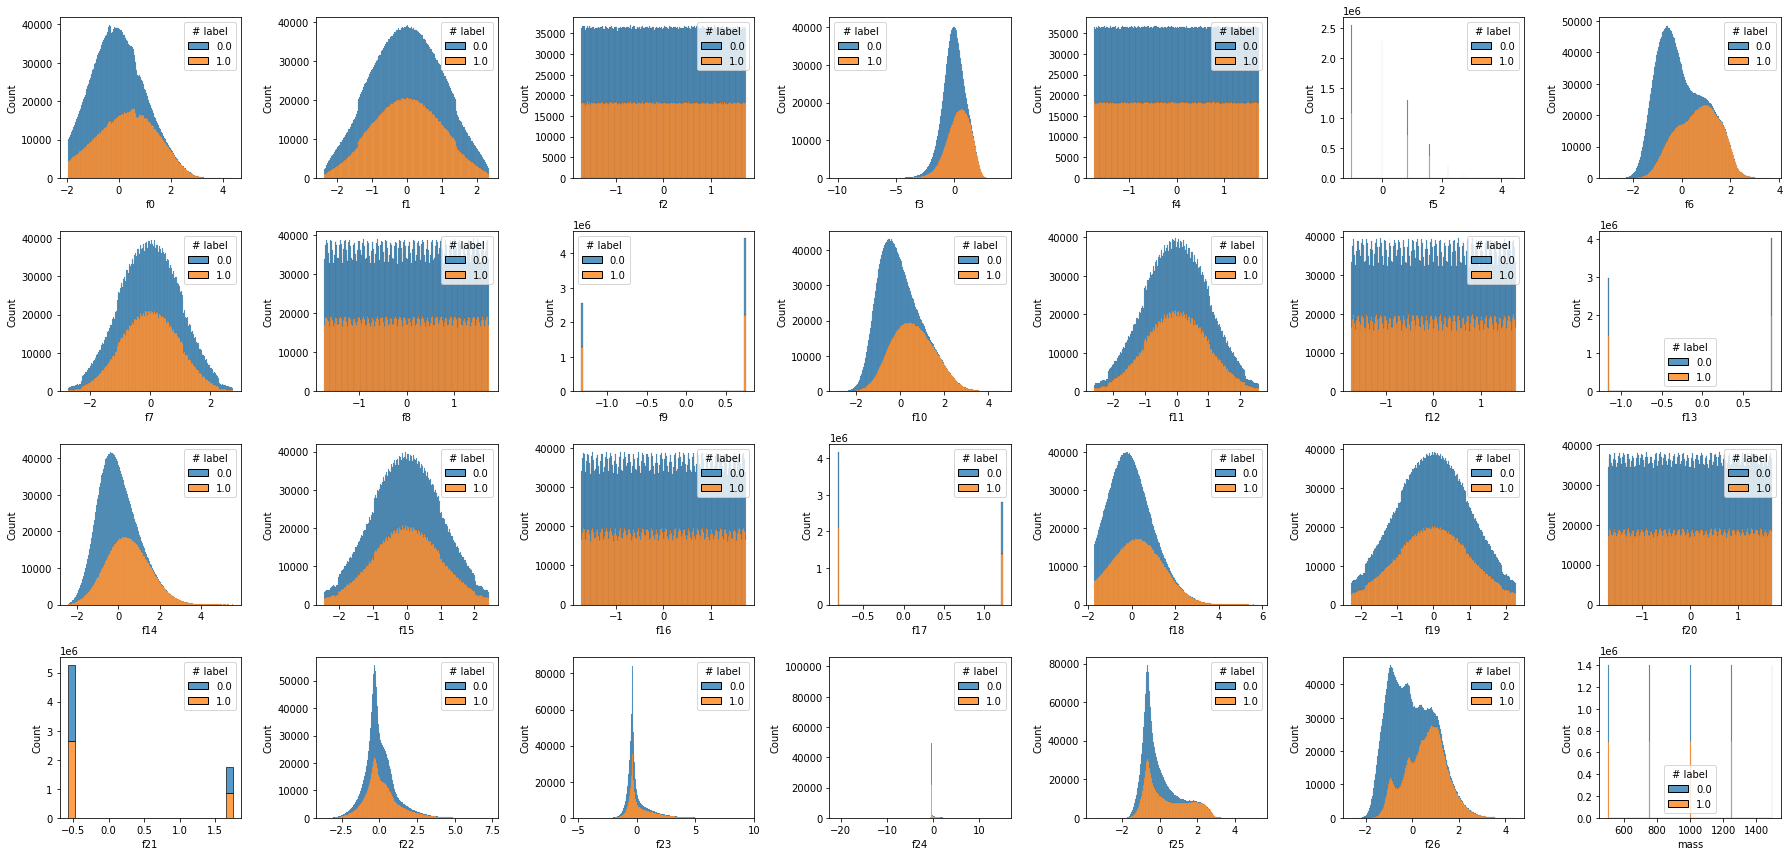

In [10]:
df_features = df.copy()
df_features.drop(["# label"], axis=1, inplace=True)

fig,axs = plt.subplots(4,7, figsize = (25,12))
h, v = 0, 0
for i in df_features.columns:
    sns.histplot(data=df, x=i, hue='# label', multiple='stack', ax=axs[h, v])
    if v == 6:
        h += 1
        v = -1
    v += 1
fig.tight_layout()


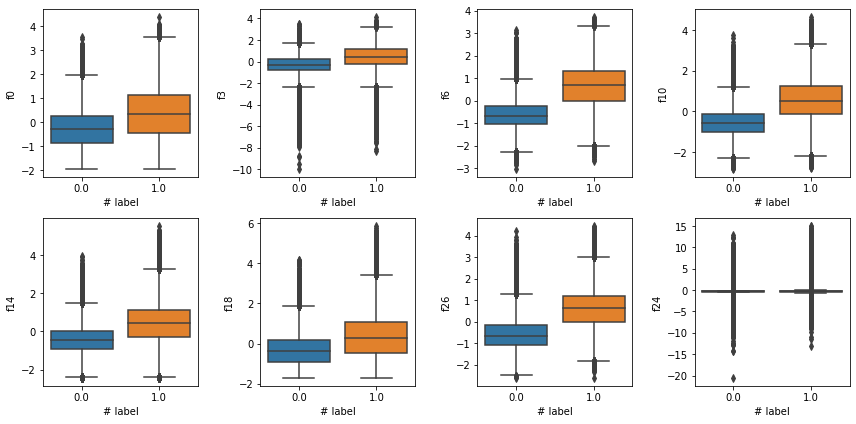

In [11]:
fig,axs = plt.subplots(2, 4, figsize = (12, 6))

sns.boxplot(data=df, x='# label', y='f0', ax=axs[0, 0])
sns.boxplot(data=df, x='# label', y='f3', ax=axs[0, 1])
sns.boxplot(data=df, x='# label', y='f6', ax=axs[0, 2])
sns.boxplot(data=df, x='# label', y='f10', ax=axs[0, 3])
sns.boxplot(data=df, x='# label', y='f14', ax=axs[1, 0])
sns.boxplot(data=df, x='# label', y='f18', ax=axs[1, 1])
sns.boxplot(data=df, x='# label', y='f26', ax=axs[1, 2])
sns.boxplot(data=df, x='# label', y='f24', ax=axs[1, 3])

fig.tight_layout()

<AxesSubplot:>

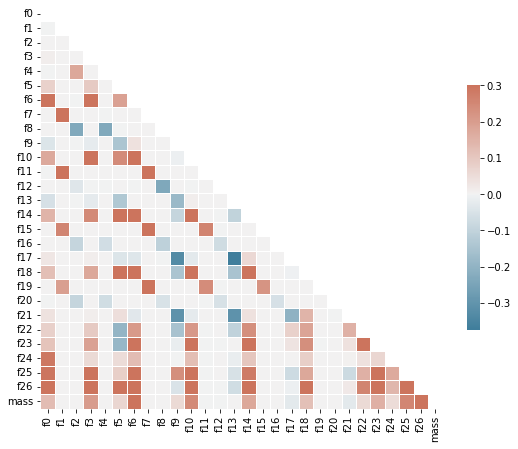

In [12]:
# Get correlation
corr = df_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

---
<img src="https://miro.medium.com/max/1400/1*bhFifratH9DjKqMBTeQG5A.gif" style="float: right" width="500"/>

### Classification Model Introduction

To approach the objectives of this case study, we used **Dense Neural Network Model**. There are multiple advantages of the algorithm that we aould like to mention here:
- The dataset of 7 million rows, consisting of prodominetly continuous values, is sufficient to train for a neural networks model.
- We are aware that it is close to impossible to interpret a Neural Network model and since interpability is not a requirement, we strongly believe that using Neural Network model is suitable for this study.
- Neural Network can be expected to self-train quite efficiently in case of problems where the relationships are dynamic or nonlinear.

#### **Neural Network**
Neural Network or Artificial Neural Network (ANN) is computing system inspired by biological neural network that constitute animal brain. Such systems “learn” to perform tasks by considering examples, generally without being programmed with any task-specific rules. A Neural Network made of many units of neurons  (also referred to as a "node") which are grouped into layers.<br>

There are 3 main components of the layers:
- **Input layer** — Initial data for the neural network.
- **Hidden layer(s)** — Intermediate layer between input and output layer and place where all the computation is done.
- **Output layer** — Produce the result for given inputs.
<img src="https://miro.medium.com/max/1400/1*upfpVueoUuKPkyX3PR3KBg.png" style="float: right" width="500"/><br>

**Dense Neural Network:** A dense layer is a layer that is deeply connected with its preceding layer which means the neurons of the layer are connected to every neuron of its preceding layer.


In Neural Network Model, learning process occurs in these steps:
1. Each neuron receives one or more inputs from an external source or from other neurons.
2. Each input is multiplied by a weight to indicate the input's relative importance.
3. The sum of the weighted input(s) is fed into the neuron.
4. Bias is added to the sum of the weighted inputs.
5. An activation function within the neuron performs a calculation on the total.
6. The result is the neuron's output, which is passed to other neurons or delivered to the external world as the machine's output.
7. The output passes through a loss function or cost function that evaluates the accuracy of the neural network's prediction, and results are fed back through the network, indicating adjustments that must be made to the weights and biases.
8. The process is repeated in multiple iterations to optimize the accuracy of the output; weights and biases are adjusted with each iteration.

###### *<div style="text-align: right">Image1 Credits: https://towardsdatascience.com/everything-you-need-to-know-about-neural-networks-and-backpropagation-machine-learning-made-easy-e5285bc2be3a</div>* *<div style="text-align: right">Image2 Credits: https://towardsdatascience.com/whats-the-role-of-weights-and-bias-in-a-neural-network-4cf7e9888a0f</div>*

### Model Preparations

1. We used train_test_split function from sklearn to split the dataset into **90% of the dataset to the train and 10% to the test dataset**. To make sure that we have the validate dataset that is not invaded by model building process.
2. **StandardScaler** function from sklearn is used to scale all features.


#### Split train and test dataset

In [13]:
from sklearn.model_selection import train_test_split

model_data = df.copy()

feature_data = model_data.copy()
feature_data.drop(["# label"], axis=1, inplace=True)

target_data = model_data['# label']

# Splitted train and test dataset
X_train, X_test, y_train, y_test = train_test_split(feature_data,target_data,test_size=0.10,random_state=0)

print("Size of modeling set (to be CV split): ", X_train.shape)
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print("Size of hold back validation set: ", X_test.shape)
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

Size of modeling set (to be CV split):  (6300000, 28)
1.0    3150462
0.0    3149538
Name: # label, dtype: int64
1.0    0.500073
0.0    0.499927
Name: # label, dtype: float64
Size of hold back validation set:  (700000, 28)
1.0    350417
0.0    349583
Name: # label, dtype: int64
1.0    0.500596
0.0    0.499404
Name: # label, dtype: float64


#### Scale all features using StandardScaler

In [14]:
#Scale new predictor matrix
from sklearn.preprocessing import StandardScaler

scl_obj = StandardScaler()
scl_obj.fit(X_train)
X_train_ = scl_obj.transform(X_train)

scl_obj.fit(X_test)
X_test_ = scl_obj.transform(X_test)

#### Import TensorFlow and check for the version

In [15]:
# TensorFlow and tf.keras
import tensorflow as tf
tf.random.set_seed(1234)

print(tf.__version__)

2.9.1


---
### Model Building and Evaluation

#### **Model 1:**  Base Model
We built a base model with only 2 layers

- Six models were built and evaluated, and added more complexity with each proceeding model in efforts to improve the models performance. <br>
Adding more complexity to improve model performance does put your model at risk of overfitting.<br>
Overfitting was addressed during the model building phase by using regularization and dropout layers. <br>
During the evaluation phase overfitting was accounted for by evaluating the models accuracy and loss on the hold out set.<br>

### Metric Functions

In [30]:
# import keras.backend as K

# # define metrics
# def Recall(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def Precision(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def F1(y_true, y_pred):
#     precision = Precision(y_true, y_pred)
#     recall = Recall(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [144]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# This callback will stop the training when there is no improvement in the loss for three consecutive epochs.


def compile_and_fit(model, model_name):

    # Compile and fit model
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    model_ = model.fit(X_train_, y_train, validation_split=0.1, epochs=100, batch_size=10000, verbose=0, callbacks=[callback])

    # Evaluate model
    e = model.evaluate(X_test_, y_test, batch_size=10000)

    # Add model name to evaluation object
    e.insert(0, model_name)

    # Convert eval into a df
    test_m = pd.DataFrame([e])
    test_m.columns = ['model','loss','acc']

    return model_.history, test_m

In [145]:
models_histories = {}
test_matrices = pd.DataFrame()

In [146]:
# Model 1
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                      
])

h, t = compile_and_fit(model1, 'Model 1')
models_histories['Model 1'] = h
test_matrices = pd.concat([test_matrices, t])


70/70 [==============================] - 0s 4ms/step - loss: 0.2706 - accuracy: 0.8774


In [147]:
# Model 2
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t = compile_and_fit(model2, 'Model 2')
models_histories['Model 2'] = h
test_matrices = pd.concat([test_matrices, t])

70/70 [==============================] - 1s 8ms/step - loss: 0.2611 - accuracy: 0.8825


In [148]:
# Model 3
model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t = compile_and_fit(model3, 'Model 3')
models_histories['Model 3'] = h
test_matrices = pd.concat([test_matrices, t])

70/70 [==============================] - 1s 7ms/step - loss: 0.2587 - accuracy: 0.8836


In [149]:
test_matrices

,model,loss,acc
0,Model 1,0.270587,0.877371
0,Model 2,0.261096,0.882461
0,Model 3,0.258740,0.883574


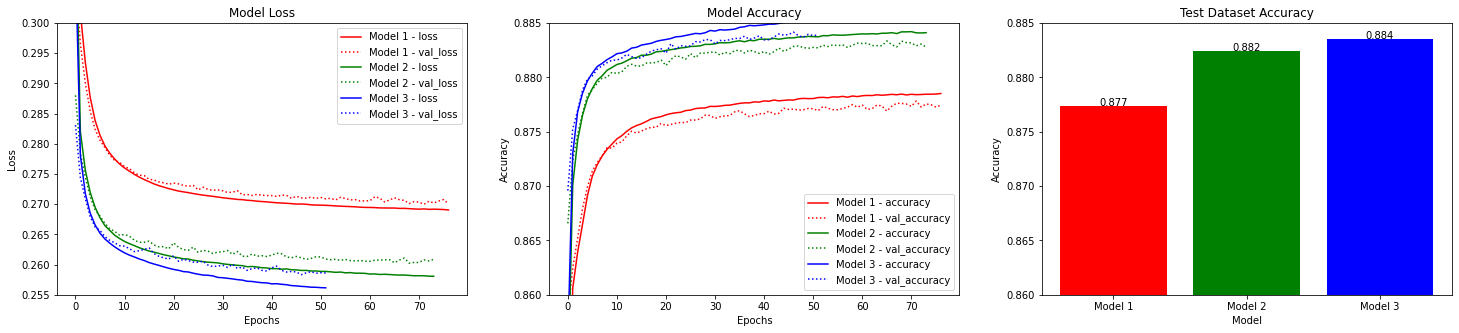

In [150]:
# plot
loss = ['loss', 'val_loss']
acc = ['accuracy', 'val_accuracy']
colors = ['red', 'green', 'blue']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,5))

ax[0].set(title="Model Loss")     
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')
ax[0].set_ylim(0.255, 0.3)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for l in loss:
        if "val" in l: 
            line='dotted'
        else:
            line='solid'
        ax[0].plot(models_histories[m][l], label=m+' - '+l, linestyle=line, color=c)
ax[0].legend()


ax[1].set(title="Model Accuracy")     
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Accuracy', color='black')
ax[1].set_ylim(0.86, 0.885)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for a in acc:
        if "val" in a: 
            line='dotted'
        else:
            line='solid'
        ax[1].plot(models_histories[m][a], label=m+' - '+a, linestyle=line, color=c)
ax[1].legend()


ax[2].set(title="Test Dataset Accuracy")     
ax[2].set_xlabel('Model')    
ax[2].set_ylabel('Accuracy', color='black')
ax[2].set_ylim(0.86, 0.885)
ax[2].bar(test_matrices['model'], test_matrices['acc'], color=colors)

label = list(test_matrices['acc'])
label_ = ['{:.3f}'.format(elem) for elem in label]

for i in range(len(label)):
    plt.text(i, label[i], label_[i], ha='center')
plt.show()

---
## Models 4 & 5

In [152]:
# Model 4
model4 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(42, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t = compile_and_fit(model4, 'Model 4')
models_histories['Model 4'] = h
test_matrices = pd.concat([test_matrices, t])

70/70 [==============================] - 1s 8ms/step - loss: 0.2691 - accuracy: 0.8806


In [153]:
# Model 5
model5 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(52, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t = compile_and_fit(model5, 'Model 5')
models_histories['Model 5'] = h
test_matrices = pd.concat([test_matrices, t])

70/70 [==============================] - 1s 10ms/step - loss: 0.2874 - accuracy: 0.8735


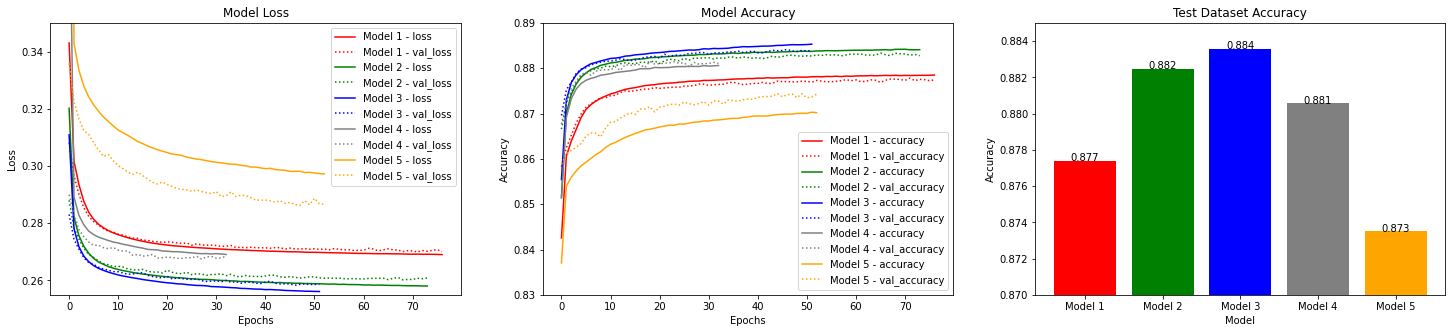

In [164]:
# plot
loss = ['loss', 'val_loss']
acc = ['accuracy', 'val_accuracy']
colors = ['red', 'green', 'blue', 'grey', 'orange']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,5))

ax[0].set(title="Model Loss")     
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')
ax[0].set_ylim(0.255, 0.35)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for l in loss:
        if "val" in l: 
            line='dotted'
        else:
            line='solid'
        ax[0].plot(models_histories[m][l], label=m+' - '+l, linestyle=line, color=c)
ax[0].legend()


ax[1].set(title="Model Accuracy")     
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Accuracy', color='black')
ax[1].set_ylim(0.83, 0.89)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for a in acc:
        if "val" in a: 
            line='dotted'
        else:
            line='solid'
        ax[1].plot(models_histories[m][a], label=m+' - '+a, linestyle=line, color=c)
ax[1].legend()


ax[2].set(title="Test Dataset Accuracy")     
ax[2].set_xlabel('Model')    
ax[2].set_ylabel('Accuracy', color='black')
ax[2].set_ylim(0.87, 0.885)
ax[2].bar(test_matrices['model'], test_matrices['acc'], color=colors)

label = list(test_matrices['acc'])
label_ = ['{:.3f}'.format(elem) for elem in label]

for i in range(len(label)):
    plt.text(i, label[i], label_[i], ha='center')
plt.show()

In [166]:
# Model 6
model6 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu', input_shape=(X_train_.shape[1], ), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t = compile_and_fit(model6, 'Model 6')
models_histories['Model 6'] = h
test_matrices = pd.concat([test_matrices, t])

70/70 [==============================] - 1s 8ms/step - loss: 0.2738 - accuracy: 0.8787


In [167]:
# Model 7
model7 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(17, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t = compile_and_fit(model7, 'Model 7')
models_histories['Model 7'] = h
test_matrices = pd.concat([test_matrices, t])

70/70 [==============================] - 1s 8ms/step - loss: 0.2635 - accuracy: 0.8825


In [168]:
# Model 8
model8 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(18, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t = compile_and_fit(model8, 'Model 8')
models_histories['Model 8'] = h
test_matrices = pd.concat([test_matrices, t])

70/70 [==============================] - 1s 8ms/step - loss: 0.2615 - accuracy: 0.8823


In [171]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# This callback will stop the training when there is no improvement in the loss for three consecutive epochs.


def compile_and_fit(model, model_name):

    # Compile and fit model
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    model_ = model.fit(X_train_, y_train, validation_split=0.1, epochs=100, batch_size=5000, verbose=0, callbacks=[callback])

    # Evaluate model
    e = model.evaluate(X_test_, y_test, batch_size=10000)

    # Add model name to evaluation object
    e.insert(0, model_name)

    # Convert eval into a df
    test_m = pd.DataFrame([e])
    test_m.columns = ['model','loss','acc']

    return model_.history, test_m


# Model 9
model9 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t = compile_and_fit(model9, 'Model 9')
models_histories['Model 9'] = h
test_matrices = pd.concat([test_matrices, t])

70/70 [==============================] - 1s 7ms/step - loss: 0.2641 - accuracy: 0.8822


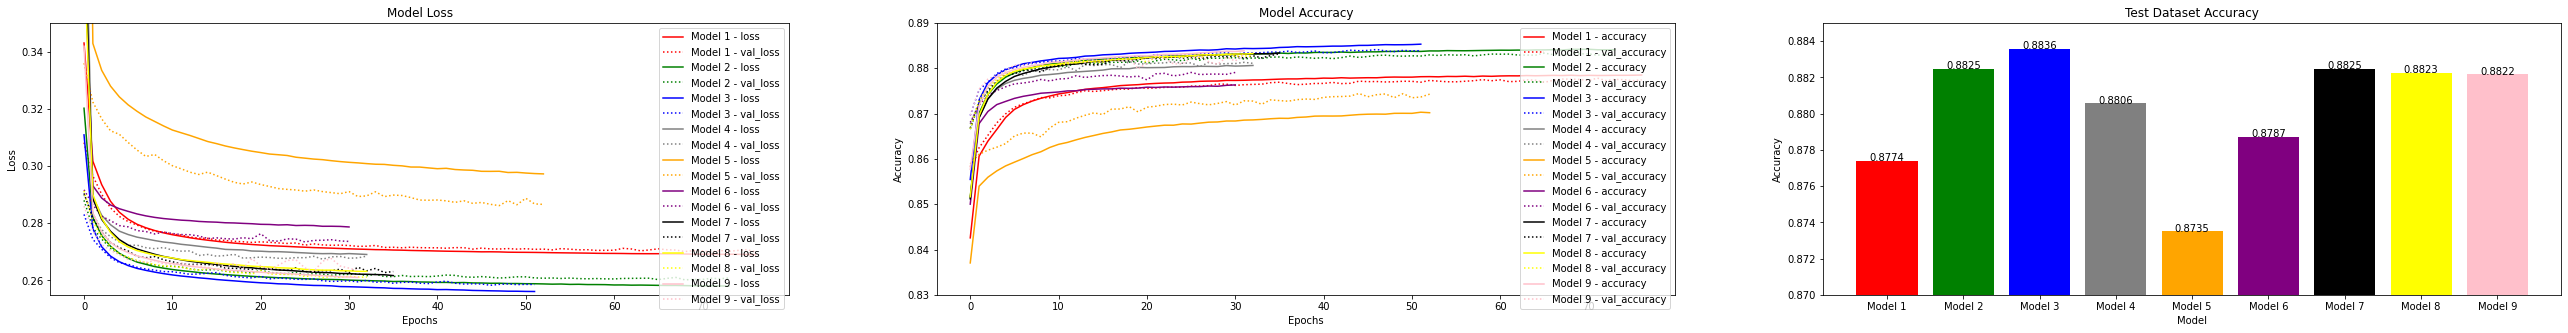

In [173]:
# plot
loss = ['loss', 'val_loss']
acc = ['accuracy', 'val_accuracy']
colors = ['red', 'green', 'blue', 'grey', 'orange', 'purple', 'black', 'yellow', 'pink']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(45,5))

ax[0].set(title="Model Loss")     
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')
ax[0].set_ylim(0.255, 0.35)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for l in loss:
        if "val" in l: 
            line='dotted'
        else:
            line='solid'
        ax[0].plot(models_histories[m][l], label=m+' - '+l, linestyle=line, color=c)
ax[0].legend()


ax[1].set(title="Model Accuracy")     
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Accuracy', color='black')
ax[1].set_ylim(0.83, 0.89)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for a in acc:
        if "val" in a: 
            line='dotted'
        else:
            line='solid'
        ax[1].plot(models_histories[m][a], label=m+' - '+a, linestyle=line, color=c)
ax[1].legend()


ax[2].set(title="Test Dataset Accuracy")     
ax[2].set_xlabel('Model')    
ax[2].set_ylabel('Accuracy', color='black')
ax[2].set_ylim(0.87, 0.885)
ax[2].bar(test_matrices['model'], test_matrices['acc'], color=colors)

label = list(test_matrices['acc'])
label_ = ['{:.4f}'.format(elem) for elem in label]

for i in range(len(label)):
    plt.text(i, label[i], label_[i], ha='center')
plt.show()

---
### Case Conclusion

- what are you proposing to your audience and why?
- How should they view your results and what should they consider when moving forward?
- Are there other approaches you'd recommend exploring?